## Baseline correction

Baseline correction removes slow changes from the system. These can either be offsets in the base line, such as a change in the overall transmission in an absorption measurement, or broad features in the spectrum, such as fluorescence in Raman spectra. 

<!-- TEASER_END -->

Baseline correction is an important step in pretreatment of spectra for further evaluation, because changes of the baseline over time can introduce spurious correlations into the dataset. For example, in FTIR spectroscopy: a slow temperature changes of an mercury cadmium telluride (MCT) detector changes its sensitivity. In absorption spectra collected at a significantly different detector temperature, the baseline will have a shape similar to the spectrum of the Globar used in the instrument. The larger the temperature difference between the background single channel and the sample single channel measurements, the more pronounced the baseline. If uncorrected for, the largest change in the spectrum will not be determined by the measured samples but by the time since the last background.

When performed incorrectly, baseline correction can introduce artifacts into the measurement as well, for example when the "anchor points" of the base line are put in a part of the spectrum with spectral features. Some of these possible mistakes are covered at the end of this post. 

## Setup

Since this is one of the more fundamental topics, I will go through the setup for the notebook as well. First we need to import **numpy** (a python package for numerical computing), **scipy** (a package that brings a vast collection of functions for numerical computing as an extension to numpy) and **matplotlib** for plotting.

`import ... as ...` imports python packages under a different name. That means, when we want to call `matplotlib.pyplot.plot()`, since we imported `matplotlib.pyplot as plt` we only need to type in `plt.plot()`.


In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

`%matplotlib notebook` is a Jupyter notebook specific magic command, that causes matplotlib plots to be displayed below the command cell they were created in. Without this command, plots are displayed in separate windows.

In [2]:
%matplotlib notebook

The dataset for this post is available in the spectroscopy_data package written for this blog. At the time of writing, the version of the package is 0.9. If you do not have the package installed or want to update it, check out this page to learn how.

In [3]:
from spectroscopy_data.pretreatment import polynomial_baseline
data = polynomial_baseline()
wn = data["wn"]
spectrum_baseline = data["spectrum_baseline"]
baseline = data["baseline"]
spectrum = data["spectrum"]

The dataset contains a spectrum with a very obvious base line and several narrower bands. Let's have a look:

<IPython.core.display.Javascript object>


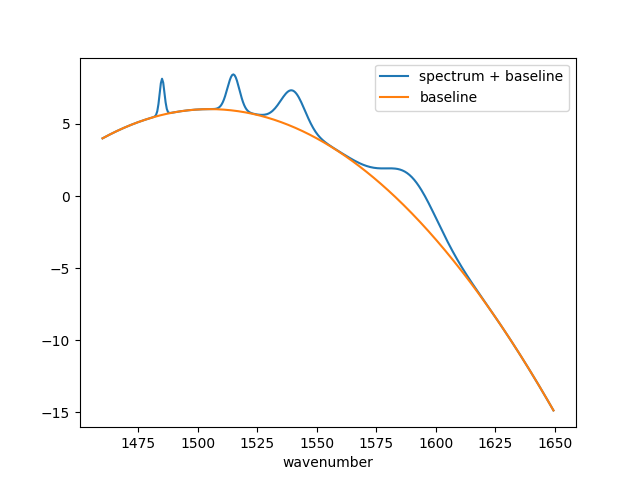

In [4]:
plt.figure()
plt.plot(wn, spectrum_baseline, label="spectrum + baseline")
plt.plot(wn, baseline, label="baseline")

plt.xlabel("wavenumber")
plt.legend()

## Polynomial baseline correction


In this case, the baseline is smooth and looks parabolic. This is a good job for a polynomial baseline correction.


Polynomial baseline correction works best for very slowly changing baselines 
that can be fit with a first or second order polynomial. First the polynomial is fit to parts of the spectrum that are devoid of signal, then the resulting fit is used to interpolate the position of the baseline to wavelengths where
absorption bands are. 

We will use `np.polyfit` to fit a polynomial to baseline, and `np.polyval` to interpolate the full spectrum. Below, we use logical indexing to grab only the wavelengths we want to fit at from the `wn` and `spectrum_baseline` arrays. First, we identify regions without bands. Here, it is best to include as many wavelengths as possible and to make sure that the edges of the spectrum are covered as well. Adding lots and lots of datapoints into the fit reduces the influence of noise, adding points at the edge of the spectrum makes sure that our fit is also constrained at the edges and does not extrapolate the baseline.

In plot below, the gray areas are going to be fit, the others are ignored for the fit.

<IPython.core.display.Javascript object>


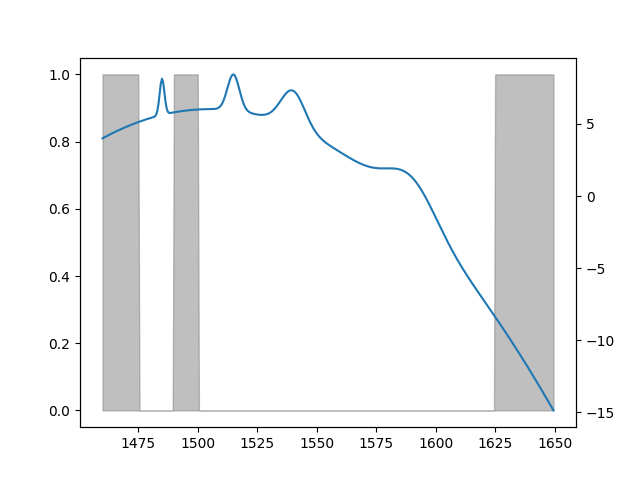

In [5]:
baseline_regions = [[1460, 1475], [1490, 1500], [1625, 1650]]
baseline_mask = np.zeros(*wn.shape, dtype=bool)
for region in baseline_regions:
    baseline_mask = baseline_mask | ((wn >= region[0]) & (wn <= region[1]))

plt.figure()
plt.fill_between(wn, baseline_mask, 0, color="grey", alpha=.5)
plt.gca().twinx().plot(wn, spectrum_baseline)

Since the baseline here is parabola, it can be easily fit with a second order polynomial. Since the baseline is also free of noise, the fit is exactly the same as the baseline.

<IPython.core.display.Javascript object>


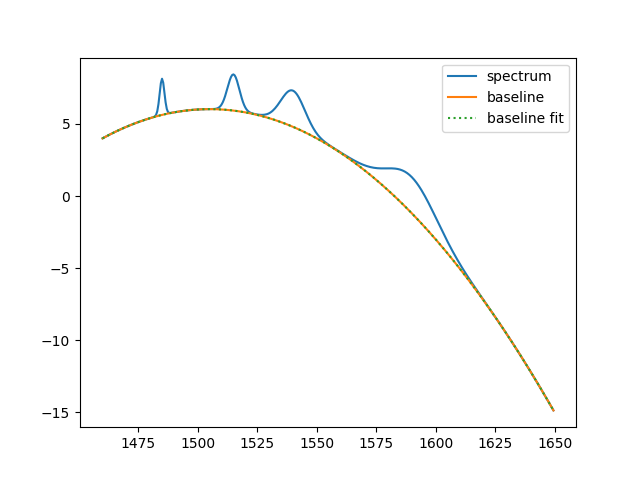

In [6]:
fit = np.polyfit(wn[baseline_mask], spectrum_baseline[baseline_mask], 2)
baseline_fit = np.polyval(fit, wn)
plt.figure()
plt.plot(wn, spectrum_baseline, label='spectrum')
plt.plot(wn, baseline, label='baseline')
plt.plot(wn, baseline_fit, ':', label='baseline fit')

After subtracting the baseline, the spectrum is recovered without distortion.

<IPython.core.display.Javascript object>


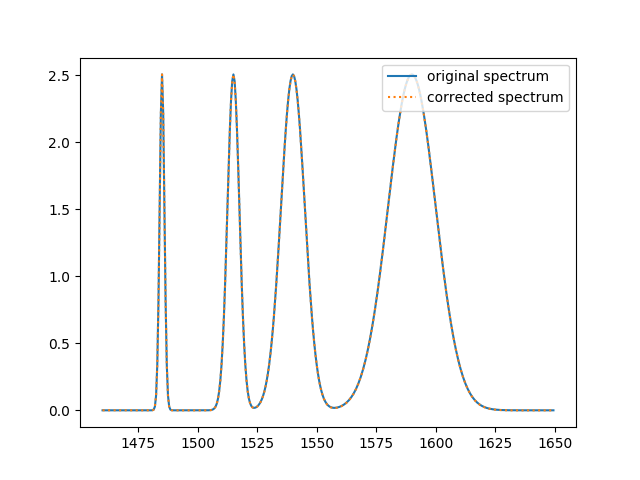

In [7]:
plt.legend()
plt.figure()
plt.plot(wn, spectrum, label='original spectrum')
plt.plot(wn, spectrum_baseline - baseline_fit, ':', label='corrected spectrum')
plt.legend(loc='upper right')

## Polynomical baseline correction: possible issues

In previous example, problems that can occur when performing baseline correction on real world data are hidden, because the data is free of noise. So, in order to see these problems, we will add a bit of noise to out baseline.

When using the previous anchor points for the baseline, we still get a pretty good fit.

<IPython.core.display.Javascript object>


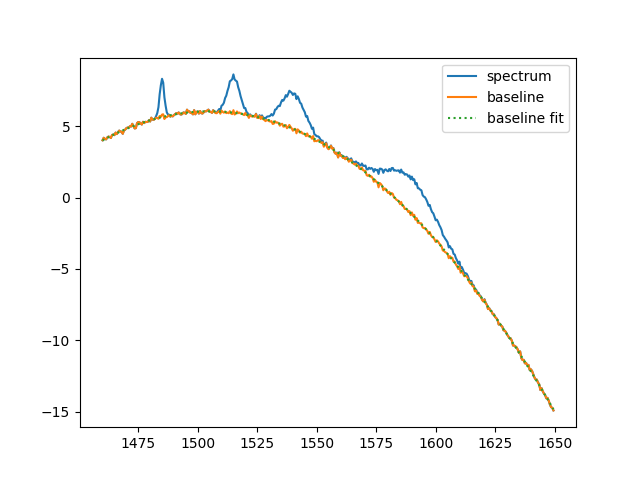

In [8]:
from numpy.random import randn

baseline_n = baseline + .1 * randn(*baseline.shape)
spectrum_baseline_n = spectrum + baseline_n
plt.figure()
plt.plot(wn, spectrum_baseline_n, label='spectrum')
plt.plot(wn, baseline_n, label='baseline')

fit = np.polyfit(wn[baseline_mask], spectrum_baseline_n[baseline_mask], 2)
baseline_fit = np.polyval(fit, wn)
plt.plot(wn, baseline_fit, ':', label='baseline fit')
plt.legend()

### Extrapolating baseline

If we don't provide anchor points for the baseline at the edges of the spectrum, than the fit will usually deviate further from the line the further we get from the anchor points.

In the plot below, the gray areas again mark the regions used for the fit.

<IPython.core.display.Javascript object>


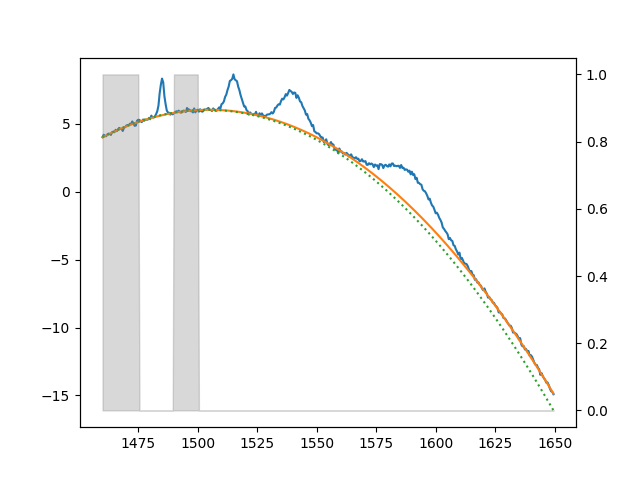

In [9]:
baseline_regions_extrap = [[1460, 1475], [1490, 1500]]

baseline_mask_extrap = np.zeros(*wn.shape, dtype=bool)
for region in baseline_regions_extrap:
    baseline_mask_extrap = baseline_mask_extrap | ((wn >= region[0]) &
                                                   (wn <= region[1]))

fit = np.polyfit(wn[baseline_mask_extrap],
                 spectrum_baseline_n[baseline_mask_extrap], 2)
baseline_fit = np.polyval(fit, wn)
plt.figure()
plt.plot(wn, spectrum_baseline_n, label='spectrum')
plt.plot(wn, baseline, label='baseline')
plt.plot(wn, baseline_fit, ':', label='baseline fit with missing edge')

plt.gca().twinx().fill_between(
    wn, baseline_mask_extrap, 0, alpha=0.3, color="grey")

### Overfitting

When the degree of the baseline polynomial is too high then the noise in the anchor point of the baseline will cause the baseline to change rapidly in the region between the anchor points. The fit tries to get as close as possible to the noisy points in the ancher regiond without regard for what this does to the shape of the baseline outside those regions.

<IPython.core.display.Javascript object>


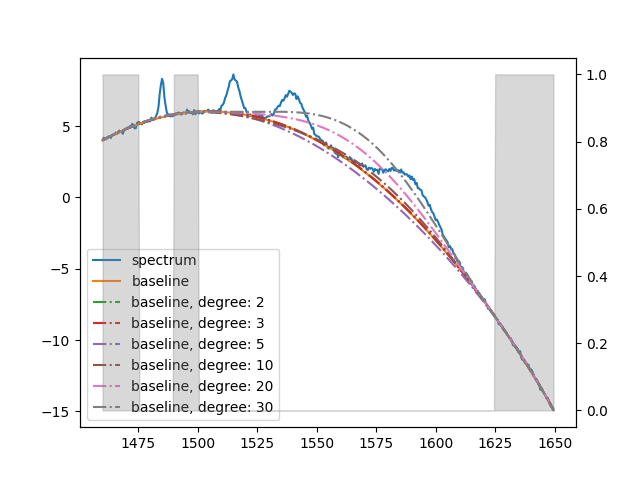

/mnt/Data/Dokumente/FREIZEIT/PROJEKTE/blog/py3-blog/lib/python3.6/site-packages/ipykernel_launcher.py:13: RankWarning: Polyfit may be poorly conditioned
  del sys.path[0]
/mnt/Data/Dokumente/FREIZEIT/PROJEKTE/blog/py3-blog/lib/python3.6/site-packages/ipykernel_launcher.py:13: RankWarning: Polyfit may be poorly conditioned
  del sys.path[0]
/mnt/Data/Dokumente/FREIZEIT/PROJEKTE/blog/py3-blog/lib/python3.6/site-packages/ipykernel_launcher.py:13: RankWarning: Polyfit may be poorly conditioned
  del sys.path[0]


In [10]:
baseline_regions_overfit = [[1460, 1475], [1490, 1500], [1625, 1650]]

baseline_mask_overfit = np.zeros(*wn.shape, dtype=bool)
for region in baseline_regions_overfit:
    baseline_mask_overfit = baseline_mask_overfit | ((wn >= region[0]) &
                                                     (wn <= region[1]))

plt.figure()
plt.plot(wn, spectrum_baseline_n, label='spectrum')
plt.plot(wn, baseline, label='baseline')
for degree in [2, 3, 5, 10, 20, 30]:
    fit = np.polyfit(wn[baseline_mask_overfit],
                     spectrum_baseline_n[baseline_mask_overfit], degree)
    baseline_fit = np.polyval(fit, wn)
    plt.plot(
        wn, baseline_fit, '-.', label='baseline, degree: {}'.format(degree))
plt.legend()

plt.gca().twinx().fill_between(
    wn, baseline_mask_overfit, 0, alpha=0.3, color="grey")

### Band included in baseline

<IPython.core.display.Javascript object>


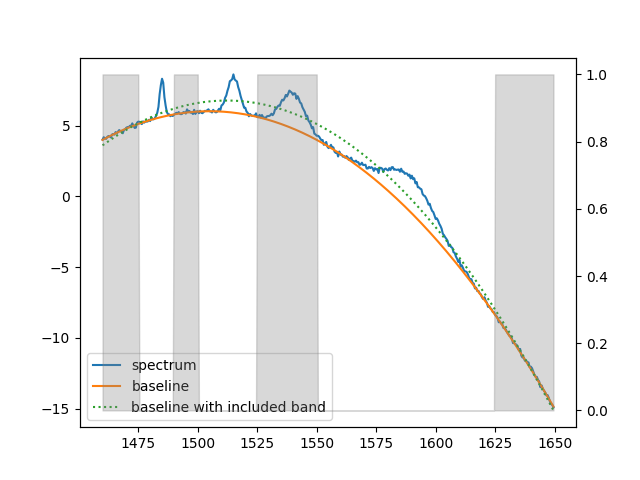

In [11]:
baseline_regions_band = [
    [1460, 1475],
    [1490, 1500],
    [1525, 1550],
    [1625, 1650],
    ]

baseline_mask_band = np.zeros(*wn.shape, dtype=bool)
for region in baseline_regions_band:
    baseline_mask_band = baseline_mask_band | ((wn >= region[0]) &
                                               (wn <= region[1]))

fit = np.polyfit(wn[baseline_mask_band],
                 spectrum_baseline_n[baseline_mask_band], 2)
baseline_fit = np.polyval(fit, wn)
plt.figure()
plt.plot(wn, spectrum_baseline_n, label='spectrum')
plt.plot(wn, baseline, label='baseline')
plt.plot(wn, baseline_fit, ':', label='baseline with included band')

plt.legend()

plt.gca().twinx().fill_between(
    wn, baseline_mask_band, 0, alpha=0.3, color="grey")